1. 폰트 설정

In [1]:
# 나눔 폰트 설치 및 matplotlib 캐시 초기화
!apt-get update -qq
!apt-get install -qq -y fonts-nanum
!rm -rf ~/.cache/matplotlib

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 나눔고딕 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)
mpl.rcParams['font.family'] = font_prop.get_name()
mpl.rcParams['axes.unicode_minus'] = False  # 마이너스 표시 문제 해결

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 123630 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


2. 데이터 준비

In [4]:
# 데이터 로드
kbo_hitter_data = pd.read_csv("/content/kbo_Hitter_data.csv")

# 연도별 팀 데이터 집계
team_yearly_data = kbo_hitter_data.groupby(['Year', 'Team']).sum()[['PA', 'H', 'HR', 'RBI']].reset_index()
team_yearly_data['AVG'] = team_yearly_data['H'] / team_yearly_data['PA']  # 팀 평균 타율 계산

# 2025년 예측을 위해 데이터 준비
past_data = team_yearly_data[team_yearly_data['Year'] < 2025]
X = past_data[['PA', 'H', 'HR', 'RBI']]
y = past_data['AVG']

# 데이터 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

3. 학습 데이터 설정 및 학습

In [5]:
# 학습 및 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=50)

# 선형 회귀 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 모델 평가
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# 정확도 계산(임계값 이내)
accuracy_threshold = 0.01  # 정확도 예측을 위한 임계값
train_accuracy = sum(abs(y_train_pred - y_train) <= accuracy_threshold) / len(y_train)
test_accuracy = sum(abs(y_test_pred - y_test) <= accuracy_threshold) / len(y_test)

# 학습 정확도 출력
print(f"Training Loss (MAE): {train_mae:.4f}, R²: {train_r2:.4f}, Accuracy: {train_accuracy:.4%}")
print(f"Testing Loss (MAE): {test_mae:.4f}, R²: {test_r2:.4f}, Accuracy: {test_accuracy:.4%}")

Training Loss (MAE): 0.0045, R²: 0.8324, Accuracy: 90.5405%
Testing Loss (MAE): 0.0038, R²: 0.8465, Accuracy: 89.4737%


4. 2025년 팀 평균 타율 예측

In [7]:
# 2025년 팀 평균 타율 예측 (최근 5년 데이터로)
recent_data = team_yearly_data[team_yearly_data['Year'] >= 2020][['PA', 'H', 'HR', 'RBI']]  # 최근 5년
recent_data_scaled = scaler.transform(recent_data)
predicted_avg_2025 = model.predict(recent_data_scaled)

# 2025년 예측 결과 추가
future_2025 = team_yearly_data[team_yearly_data['Year'] == 2024].copy()
future_2025['Year'] = 2025
future_2025['Predicted_AVG'] = predicted_avg_2025[-len(future_2025):]

# 결과 병합
final_results = pd.concat([team_yearly_data, future_2025])

5. 예측한 팀 평균 타율 시각화

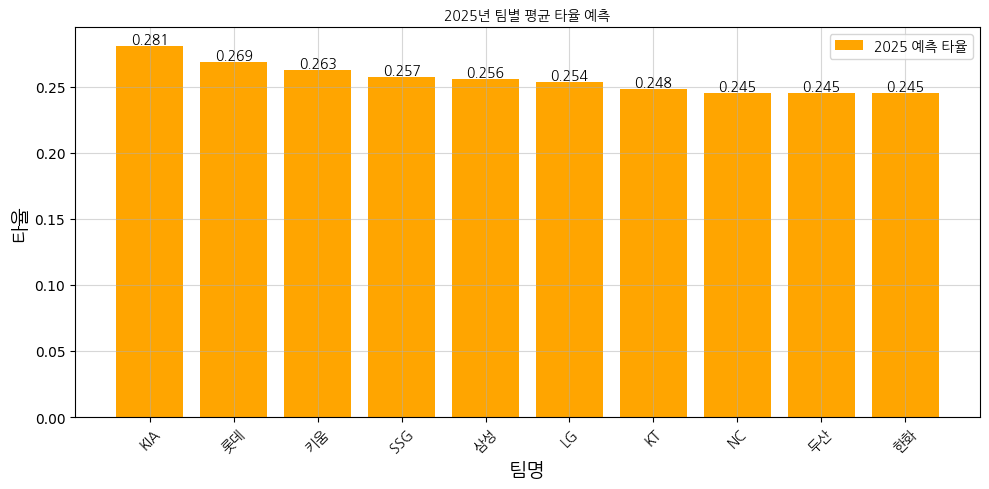

In [9]:
# 2025년 예측 시각화
future_2025_sorted = future_2025.sort_values(by='Predicted_AVG', ascending=False)
plt.figure(figsize=(10, 5))
team_names = future_2025_sorted['Team']
predicted_avgs = future_2025_sorted['Predicted_AVG']

bars = plt.bar(team_names, predicted_avgs, color='orange', label='2025 예측 타율')

# 각 바 위에 타율 표시 (소수점 3자리까지)
for bar, avg in zip(bars, predicted_avgs):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{avg:.3f}', ha='center', va='bottom', fontsize=10, fontproperties=font_prop)

plt.title('2025년 팀별 평균 타율 예측', fontsize=16, fontproperties=font_prop)
plt.xlabel('팀명', fontsize=14, fontproperties=font_prop)
plt.ylabel('타율', fontsize=14, fontproperties=font_prop)
plt.xticks(fontsize=12, fontproperties=font_prop, rotation=45)
plt.legend(fontsize=12, prop=font_prop)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

6. 2004년부터 2024년까지 20년치의 팀 타율 / 2025년 예측 팀 타율 결과 파일 저장

In [ ]:
# 결과를 CSV로 저장
output_file = "team_batting_predictions_2025_sorted.csv"
final_results.to_csv(output_file, index=False)
print(f"Predictions saved to {output_file}")

Predictions saved to team_batting_predictions_2025_sorted.csv
